# Data Acquisition

In [3]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
import prepare

In [18]:
# import data - train
df = pd.read_csv('train.csv')
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


## Summary of initial observation

1. Raw dataset: 12 columns & 111,753 rows

2. Raw data quite complete! Detail can be found in Table 1. 

> **Table 1: Summary of Columns Containing Missing Value** 
>
> Name & Outcome Subtypes missing the most amount of data.

3. Initial run will completely ignore outcome subtype.

4. Feature engineering - Name, age upon outcome, sex, breed, color

5. Hypothesis:

> - Name - animals with names get better outcomes, any name associate with better outcome?
> 
> - Age, sex, breed, color each might also make a difference in animal fate


In [19]:
# peek at the df dimension
df.shape

(26729, 10)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.0+ MB


### Examine missing values

#### Table 1: Summary of Columns Containing Missing Value

In [32]:
# list missing value by col
# need to decide what to do
print("Table 1: Summary of Columns Containing Missing Value")
prepare.report_col_with_null_df(df)

Table 1: Summary of Columns Containing Missing Value


,0,1,2,3
0,Name,OutcomeSubtype,SexuponOutcome,AgeuponOutcome
0,7691,13612,1,18


In [33]:
# view missing data by percentage
pd.DataFrame(df.apply(lambda x: round(sum(x.isnull()/len(df)),3))).T

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,0.0,0.288,0.0,0.0,0.509,0.0,0.0,0.001,0.0,0.0


### Examine data type & understand variables
e.g. if there are redundant variables, etc.

In [37]:
df.info()
# notes:

# all columns are object types
# MonthYear seemed to be same with DateTime, may drop the col
# animal type maybe just parse dog and cat into 2 df and drop the other species for this analysis

# Derive age from DOB may be more useful?
# age upon outcome might be used instead of calculating age from DOB
# DOB/ age, age upon outcome, sex, breed, color might be the most valuable for prediction

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.0+ MB


In [35]:
# double check if DateTime & MonthYear columns are identical
# Yes, so we can safely remove MonthYear
#(df["DateTime"] == df["MonthYear"]).mean()

In [39]:
# compare information in the 2 columns, outcome type and outcome subtype 
# seems like for the first iteration, we can safely remove outcome subtype

# for one it does miss a good portion of data
# for second, the information doesn't seem particularly helpful

print(f"""
What does 'Outcome Type' column tell us?

{df['OutcomeType'].unique()}
-------------------------------------------
      
How does 'Outcome Subtype' Differ?

{df['OutcomeSubtype'].unique()}
""")


What does 'Outcome Type' column tell us?

['Return_to_owner' 'Euthanasia' 'Adoption' 'Transfer' 'Died']
-------------------------------------------
      
How does 'Outcome Subtype' Differ?

[nan 'Suffering' 'Foster' 'Partner' 'Offsite' 'SCRP' 'Aggressive'
 'Behavior' 'Rabies Risk' 'Medical' 'In Kennel' 'In Foster' 'Barn'
 'Court/Investigation' 'Enroute' 'At Vet' 'In Surgery']



**Decision for handling missing data**
- Name: transform into has_name, no_name

- Outcome Subtype: seems like we can temperarily just **drop column**

- Sex upon outcome: **dropna** we can afford dropping the 1 missing value
> **feature engineer** extract only sex/ intact or not, and drop unknown

- Age upon outcome: **dropna, feature engineer** convert into day/int

In [42]:
# drop unnecessary columns or columns with too many missing value

df.drop(columns = ['AnimalID', 'DateTime', 'OutcomeSubtype'], inplace = True)

In [44]:
# drop the missing values
# df.dropna(inplace = True)
df.dropna(subset=['SexuponOutcome','AgeuponOutcome'], inplace = True)

In [47]:
# rename the columns for easier typing

df.rename(columns = ({'OutcomeType':'outcome', 
                      'AnimalType': 'species', 
                      'SexuponOutcome': 'sex',
                      'AgeuponOutcome': 'age_destiny', 
                      'Breed': 'breed', 
                      'Color': 'color',
                      'Name': 'name'}), inplace = True)

In [50]:
# might run into imbalanced data problem when modeling...
# for example, number of Died animals ~0.7% of total dataset
# even if adding Died & Euthanasia > 6.5% still very low in number

# another case is neutered/ spayed versus intact-male/female 
# need to drop unknown because there's no way to know the real data

for c in df.columns.to_list():
    print("""The types of data and the respective counts in {} is 
{}""".format(c,(df[c].value_counts())))

The types of data and the respective counts in name is 
Max        136
Bella      135
Charlie    107
Daisy      106
Lucy        94
          ... 
Vance        1
Oso Jr       1
Fuzzo        1
Heart        1
Curious      1
Name: name, Length: 6374, dtype: int64
The types of data and the respective counts in outcome is 
Adoption           10769
Transfer            9406
Return_to_owner     4785
Euthanasia          1553
Died                 197
Name: outcome, dtype: int64
The types of data and the respective counts in species is 
Dog    15593
Cat    11117
Name: species, dtype: int64
The types of data and the respective counts in sex is 
Neutered Male    9779
Spayed Female    8819
Intact Male      3519
Intact Female    3504
Unknown          1089
Name: sex, dtype: int64
The types of data and the respective counts in age_destiny is 
1 year       3969
2 years      3742
2 months     3397
3 years      1823
1 month      1281
3 months     1277
4 years      1071
5 years       992
4 months      888
6

Text(0.5, 1, 'What are the different outcomes of shelter animals by animal counts?')

<Figure size 1440x360 with 0 Axes>

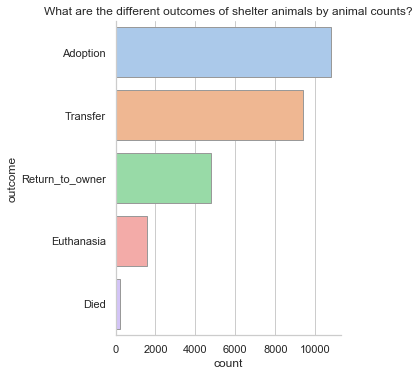

In [53]:
# peek the animal counts in different outcome
plt.figure(figsize=(20,5))
sns.catplot(y="outcome", kind="count",
            palette="pastel", edgecolor=".6",
            data=df,
            order = ["Adoption", "Transfer", "Return_to_owner", "Euthanasia", "Died"])
plt.title("What are the different outcomes of shelter animals by animal counts?")

**Begin feature engineering**

1. Sex upon Outcome	
> extract only sex, and drop the other parts in the col

2. Age upon Outcome
> convert into year/int

In [12]:
# take a look at the different data formats

# easy enough, just mask the raws containing 'Male' or 'Female' 
# reassign as only the sex perspectively to the original col

df.sex.unique()

array(['Neutered Male', 'Intact Male', 'Intact Female', 'Spayed Female',
       'Unknown'], dtype=object)

In [16]:
# check outcomes types:

# RTO means return to owner
# so need to combine 'Return to Owner' and 'Rto-Adopt'

df.outcome.unique()

array(['Adoption', 'Return to Owner', 'Transfer', 'Rto-Adopt',
       'Euthanasia', 'Died', 'Missing', 'Disposal'], dtype=object)

<Figure size 2880x2880 with 0 Axes>

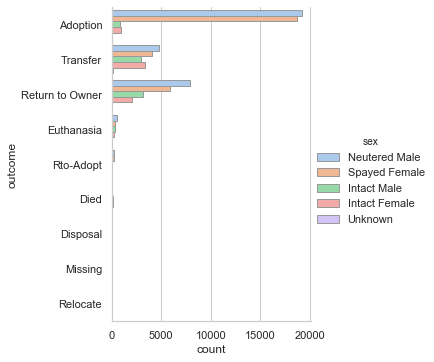

In [17]:
# explore if there's a difference between neutered/ intact
plt.figure(figsize=(40,40))
sns.catplot(y="outcome", hue="sex", kind="count",
            palette="pastel", edgecolor=".6",
            data=df,
            order = ['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia','Rto-Adopt', 'Died', 'Disposal', 'Missing', 'Relocate'],
            hue_order = ['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female','Unknown'])

<Figure size 1440x720 with 0 Axes>

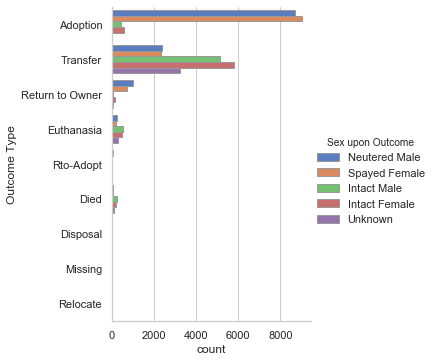

In [18]:
# cat-only: explore if there's a difference between neutered/ spayed & intact 

# Adopted ones, neutered/spayed definitely much more than intact
# higher % of intact cats get transfered
# WHAT DOES TRANSFER REALLY MEANS???

# Look at underlying info: intact vs non-intact

# compared with dogs, there's is a higher proportion of cats get transfered
# dogs shows higher return to owner rate
plt.figure(figsize=(20,10))
sns.catplot(y="Outcome Type", hue="Sex upon Outcome", kind="count",
            palette="muted", edgecolor=".6",
            data=cat,
            order = ['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia','Rto-Adopt', 'Died', 'Disposal', 'Missing', 'Relocate'],
            hue_order = ['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female','Unknown'])

<Figure size 1440x720 with 0 Axes>

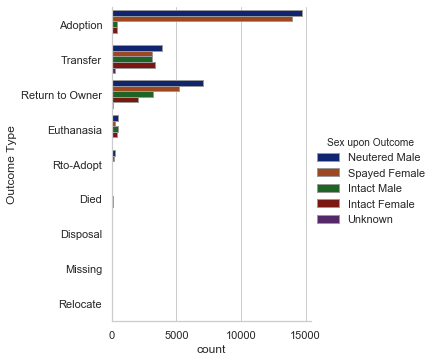

In [19]:
# dog-only: explore if there's a difference between neutered/ spayed & intact
plt.figure(figsize=(20,10))
sns.catplot(y="Outcome Type", hue="Sex upon Outcome", kind="count",
            palette="dark", edgecolor=".6",
            data=dog,
            order = ['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia','Rto-Adopt', 'Died', 'Disposal', 'Missing', 'Relocate'],
            hue_order = ['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female','Unknown'])

In [65]:
df['sex_transformed'] = df.sex
df.loc[df.sex_transformed.str.contains('Male'), 'sex_transformed'] = 'Male'
df.loc[df.sex_transformed.str.contains('Female'),'sex_transformed'] = 'Female'

In [21]:
# handle Age upon Outcome
# use "day" as unit for all results

In [66]:
# split the numbers and units into 2 columns for unit conversion
df['age_number'], df['age_unit'] = zip(*df.age_destiny.str.split(' '))

In [67]:
# convert data type for downstream calculation
df.age_number = df.age_number.astype(int)

In [68]:
x = df.age_unit
# set conditions
# strings contain week, month, year need conversion
# strings contain day remain the same
condlist = ([
    x.str.contains('week'),
    x.str.contains('month'),
    x.str.contains('year'),
    x.str.contains('day')
            ])
# when meeting the quiteria, do these math
choicelist = (df.age_number * 7,
              df.age_number * 30.5, 
              df.age_number * 365,
              df.age_number)
# store info back into df after conversion
df['age_transformed'] = np.select(condlist, choicelist)

In [69]:
# take a look at df, now we need to drop some columns again
df.head(5)

,name,date_time,outcome,species,sex,age_destiny,breed,color,sex_transformed,age_number,age_unit,age_transformed
0,Moose,02/13/2016 05:59:00 PM,Adoption,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff,Male,4,months,122.0
1,NaN,03/18/2014 11:47:00 AM,Transfer,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby,Male,6,days,6.0
2,*Donatello,10/18/2014 06:52:00 PM,Adoption,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black,Male,2,months,61.0
3,*Zeus,08/05/2014 04:59:00 PM,Adoption,Cat,Neutered Male,2 months,Domestic Shorthair Mix,White/Orange Tabby,Male,2,months,61.0
4,NaN,07/27/2014 09:00:00 AM,Transfer,Cat,Intact Female,2 years,Domestic Shorthair Mix,Black,Female,2,years,730.0


In [70]:
df.drop(columns = ['age_number', 'age_unit'], inplace = True)

In [71]:
df = df[['date_time', 'name', 'outcome', 'species', 'sex','sex_transformed', 'breed','color', 'age_destiny', 'age_transformed']]

In [72]:
from scipy import stats

In [73]:
# average age of neutered/spayed vs intact

# male
intact_male_dog = df[(df.sex.str.contains('Intact')) & (df.sex_transformed == "Male") & (df.species == "Dog")].age_transformed
neutered_male_dog = df[(df.sex.str.contains('Neutered')) & (df.sex_transformed == "Male") & (df.species == "Dog")].age_transformed
# female
intact_female_dog = df[(df.sex.str.contains('Intact')) & (df.sex_transformed == "Female") & (df.species == "Dog")].age_transformed
spayed_female_dog = df[(df.sex.str.contains('Spayed')) & (df.sex_transformed == "Female") & (df.species == "Dog")].age_transformed

In [74]:
print("""
The average age of intact male dogs is: {:.2f}
The average age of neutered male dogs is: {:.2f}
--
The average age of intact female dogs is: {:.2f}
The average age of spayed female dogs is: {:.2f}
"""
      .format(neutered_male_dog.mean(), intact_male_dog.mean(), 
              spayed_female_dog.mean(), intact_female_dog.mean()))


The average age of intact male dogs is: 1023.87
The average age of neutered male dogs is: 870.21
--
The average age of intact female dogs is: 988.06
The average age of spayed female dogs is: 808.87



In [75]:
tstat, p = stats.ttest_ind(neutered_male_dog, intact_male_dog)
tstatf, pf = stats.ttest_ind(spayed_female_dog, intact_female_dog)

In [76]:
# not statistically significant
# so maybe the difference in neutering/spaying or not is not because of age
# may due to not enough HR or $ to neuter/ spay all dogs...
# so if increase the neuter/ spay rate of male dogs, 
# may be possible to increase adoption

print("""
(Comparison of the average age of intact versus neutered male dogs:
Result: {:.2f} with the p-value of {:.2f}
--
Comparison of the average age of intact versus spayed female dogs:
Result: {:.2f} with the p-value of {:.2f})
""".format(tstat, p, tstatf, pf))


(Comparison of the average age of intact versus neutered male dogs:
Result: 10.65 with the p-value of 0.00
--
Comparison of the average age of intact versus spayed female dogs:
Result: 11.30 with the p-value of 0.00)



In [77]:
dog_df = df.copy()
dog_df = df[(df.species == "Dog") & (df.sex_transformed != 'Unknown')]

In [112]:
cat_df = df.copy()
cat_df = df[(df.species == "Cat") & (df.sex_transformed != 'Unknown')]

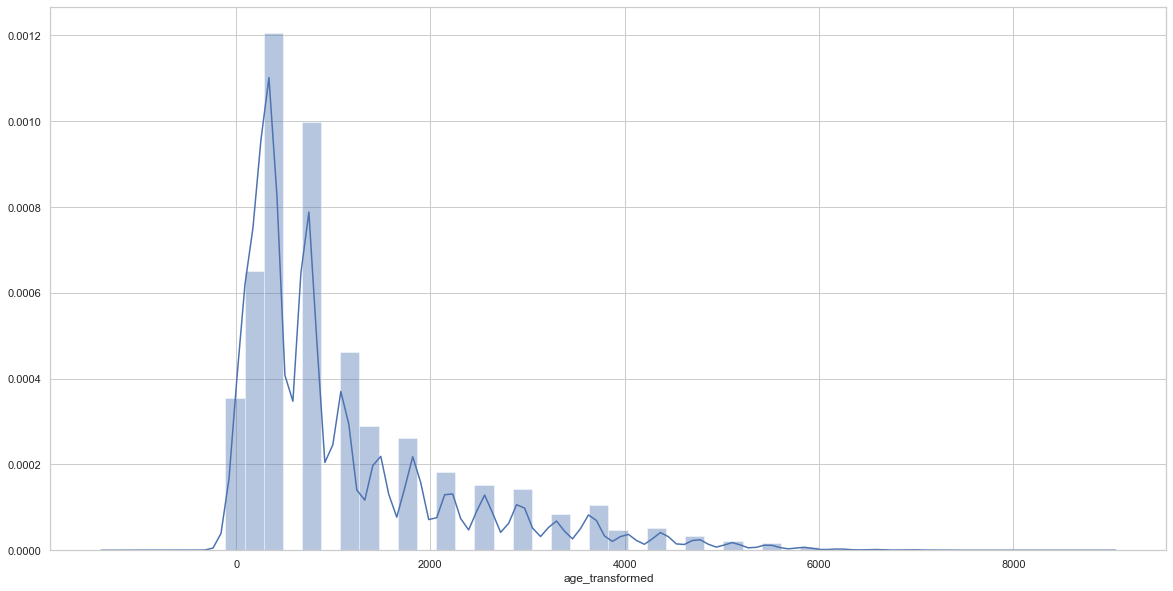

In [35]:
plt.figure(figsize = (20,10))
sns.distplot(dog_df.age_transformed)

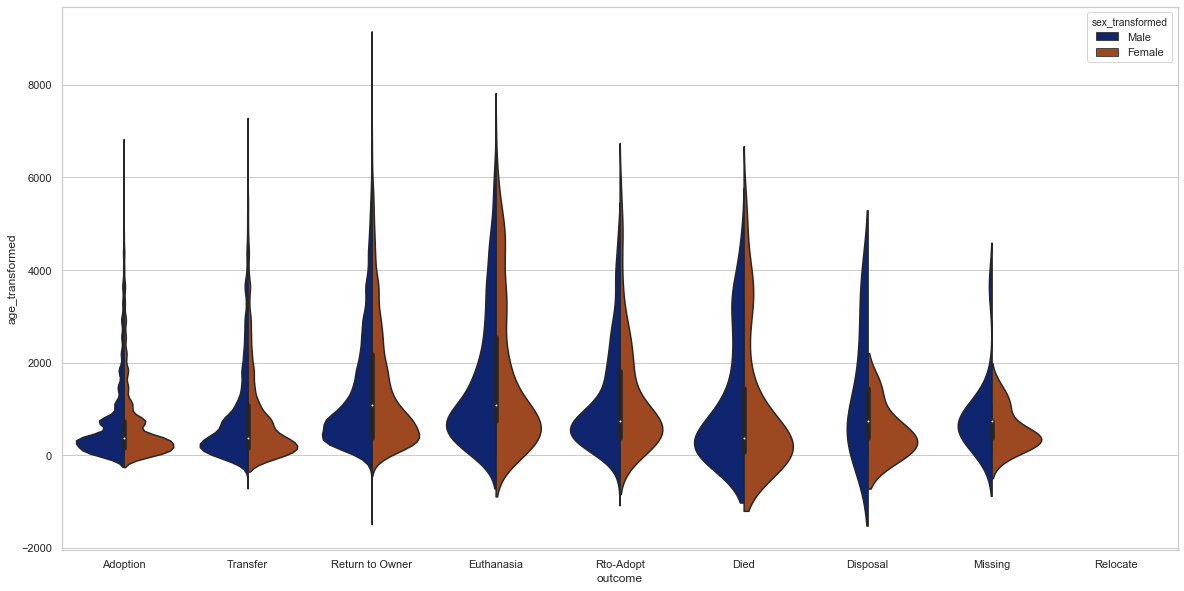

In [101]:
# dog age distribution: 
# adopted vs others
# 
plt.figure(figsize = (20,10))
sns.violinplot(x="outcome", y="age_transformed", hue="sex_transformed",
               data=dog_df, palette="dark", edgecolor=".3",
               order = ['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia','Rto-Adopt', 'Died', 'Disposal', 'Missing', 'Relocate'],
               split=True)

In [78]:
dog_df['encode_outcome'] = dog_df.outcome.apply(lambda x: 'no_adopt' if x!= 'Adoption' else x)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


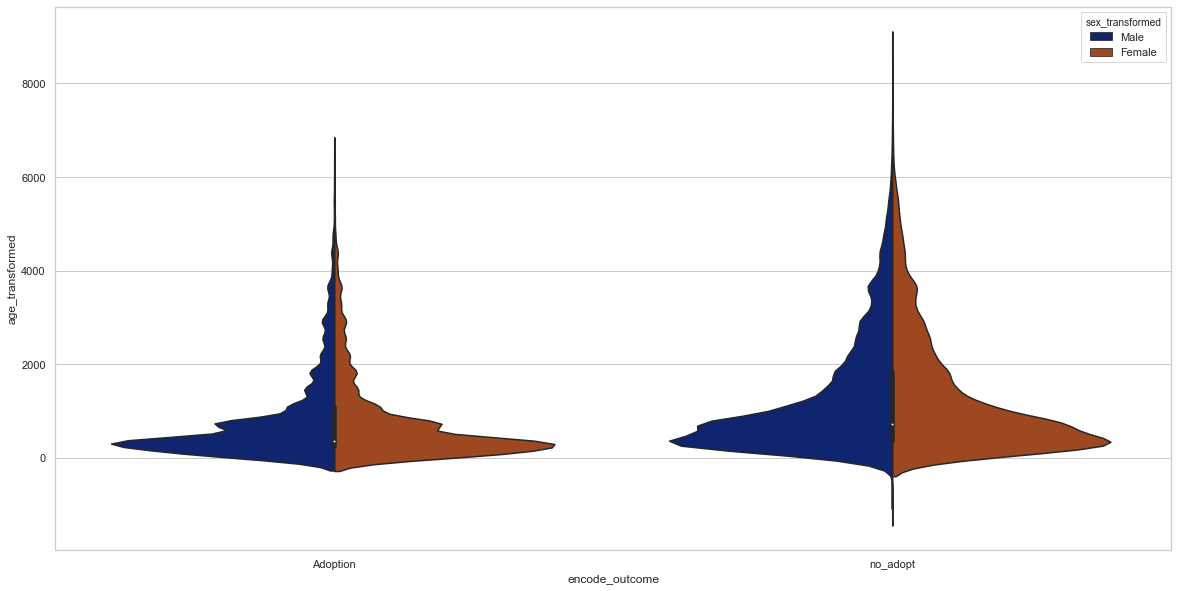

In [39]:
# visually, gender is not as big as a factor in adoption of dogs
# definitely more non-adopted dogs are older
plt.figure(figsize = (20,10))
sns.violinplot(x="encode_outcome", y="age_transformed", hue="sex_transformed",
               data=dog_df, palette="dark", edgecolor=".6",
               split=True)

In [79]:
# average age of adopted versus not-adopted dogs

# male
adopted_male_dog = dog_df[(dog_df.encode_outcome == "Adoption") & (dog_df.sex_transformed == "Male")].age_transformed
no_male_dog = dog_df[(dog_df.encode_outcome == "no_adopt") & (dog_df.sex_transformed == "Male")].age_transformed
# female
adopted_female_dog = dog_df[(dog_df.encode_outcome == "Adoption") & (dog_df.sex_transformed == "Female")].age_transformed
no_female_dog = dog_df[(dog_df.encode_outcome == "no_adopt") & (dog_df.sex_transformed == "Female")].age_transformed

In [80]:
print("""
The average age of adopted male dogs is: {:.2f}
The average age of non-adopted male dogs is: {:.2f}
--
The average age of adopted female dogs is: {:.2f}
The average age of non-adopted female dogs is: {:.2f}
"""
      .format(adopted_male_dog.mean(), no_male_dog.mean(), 
              adopted_female_dog.mean(), no_female_dog.mean()))


The average age of adopted male dogs is: 725.57
The average age of non-adopted male dogs is: 1205.22
--
The average age of adopted female dogs is: 695.81
The average age of non-adopted female dogs is: 1195.45



In [81]:
tstat, p = stats.ttest_ind(adopted_male_dog, no_male_dog)
tstatf, pf = stats.ttest_ind(adopted_female_dog, no_female_dog)

In [82]:
print("""
(Comparison of the average age of adopted versus not-adopted male dogs:
Result: {:.2f} with the p-value of {:.2f}
--
Comparison of the average age of adopted versus not-adopted female dogs:
Result: {:.2f} with the p-value of {:.2f})
""".format(tstat, p, tstatf, pf))


(Comparison of the average age of adopted versus not-adopted male dogs:
Result: -41.12 with the p-value of 0.00
--
Comparison of the average age of adopted versus not-adopted female dogs:
Result: -39.12 with the p-value of 0.00)



In [83]:
# age after 1700 days, seems like ratio started to change between adopt/ no-adopt
all_old = len(dog_df[dog_df.age_transformed > 1642])
adopted_old = len(dog_df[(dog_df.age_transformed > 1642) & (dog_df.encode_outcome == "Adoption")])
no_adopt_old = len(dog_df[(dog_df.age_transformed > 1642) & (dog_df.encode_outcome == "no_adopt")])

In [84]:
print("""
Percentage of dogs over 4.5 years old and
adopted: {:.2f}%,
not adopted: {:.2f}%
""".format(100*(adopted_old/all_old), 100*(no_adopt_old/all_old)))


Percentage of dogs over 4.5 years old and
adopted: 29.09%,
not adopted: 70.91%



In [ ]:
# write a funcion to guage the true limiting cutoff for age influencing adtoption

In [85]:
all_old = len(dog_df[dog_df.age_transformed > 2])
adopted_old = len(dog_df[(dog_df.age_transformed > 2) & (dog_df.encode_outcome == "Adoption")])
cal = adopted_old/all_old

In [119]:
age_at_adoption_d = []
adoption_rate_d = []
for age in range(1, (int(df.age_transformed.max()+1)), 365):
    all_old = len(dog_df[dog_df.age_transformed > age])
    adopted_old = len(dog_df[(dog_df.age_transformed > age) & (dog_df.encode_outcome == "Adoption")])
    cal = adopted_old/all_old
    age_at_adoption_d.append(int(age/365))
    adoption_rate_d.append(round(cal, 2))
    print("Age in year {} and relative adoption rate: {:.2f}%".format(age, cal*100))

    if cal <= 0:
        print("The time when adoption rate begin to go downhill...{:.2f}".format(age/365))
        break
    else:
        continue

Age in year 1 and relative adoption rate: 46.88%
Age in year 366 and relative adoption rate: 36.49%
Age in year 731 and relative adoption rate: 32.15%
Age in year 1096 and relative adoption rate: 30.39%
Age in year 1461 and relative adoption rate: 29.09%
Age in year 1826 and relative adoption rate: 27.30%
Age in year 2191 and relative adoption rate: 26.18%
Age in year 2556 and relative adoption rate: 25.28%
Age in year 2921 and relative adoption rate: 22.51%
Age in year 3286 and relative adoption rate: 20.34%
Age in year 3651 and relative adoption rate: 17.57%
Age in year 4016 and relative adoption rate: 16.09%
Age in year 4381 and relative adoption rate: 11.44%
Age in year 4746 and relative adoption rate: 8.64%
Age in year 5111 and relative adoption rate: 8.81%
Age in year 5476 and relative adoption rate: 5.95%
Age in year 5841 and relative adoption rate: 5.06%
Age in year 6206 and relative adoption rate: 5.00%
Age in year 6571 and relative adoption rate: 0.00%
The time when adoption 

Text(0.5, 1.0, 'Dogs are least likely to be adopted when they age?')

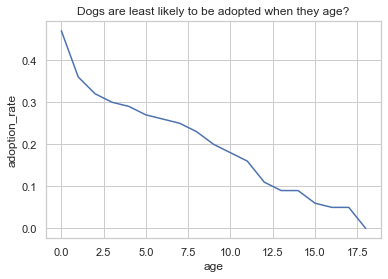

In [120]:
elbow_d = pd.DataFrame({'age': age_at_adoption_d, 'adoption_rate': adoption_rate_d})
sns.lineplot(x="age", y="adoption_rate", data=elbow_d)
plt.title("Dogs are least likely to be adopted when they age?")

In [113]:
cat_df['encode_outcome'] = cat_df.outcome.apply(lambda x: 'no_adopt' if x!= 'Adoption' else x)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


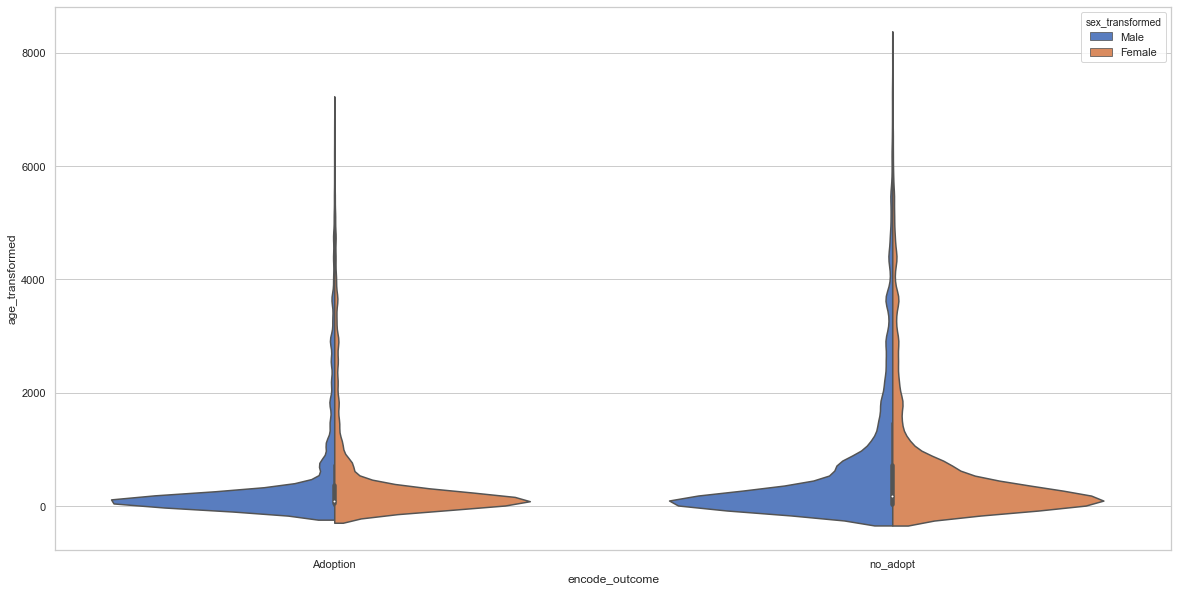

In [116]:
# older cats are less likely to be adopted
# but maybe not as obvious as dogs
plt.figure(figsize = (20,10))
sns.violinplot(x="encode_outcome", y="age_transformed", hue="sex_transformed",
               data=cat_df, palette="muted", edgecolor=".6",
               split=True, order = ['Adoption', 'no_adopt'])

In [115]:
# calculate how age of cats will become a limitimg factor for their adoption
# compared with dog adoptions, 
# older cats definitely seemed to have relative higher chance of getting adopted
age_at_adoption = []
adoption_rate = []
for age in range(1, (int(df.age_transformed.max()+1)), 365):
    all_old = len(cat_df[cat_df.age_transformed > age])
    adopted_old = len(cat_df[(cat_df.age_transformed > age) & (cat_df.encode_outcome == "Adoption")])
    cal = adopted_old/all_old
    age_at_adoption.append(int(age/365))
    adoption_rate.append(round(cal, 2))
    print("Age in year {} and relative adoption rate: {:.2f}%".format(age, cal*100))

    if cal <= 0:
        print("The time when adoption rate begin to go downhill...{:.2f}".format(age/365))
        break
    else:
        continue

Age in year 1 and relative adoption rate: 48.80%
Age in year 366 and relative adoption rate: 35.98%
Age in year 731 and relative adoption rate: 39.48%
Age in year 1096 and relative adoption rate: 39.92%
Age in year 1461 and relative adoption rate: 40.38%
Age in year 1826 and relative adoption rate: 41.15%
Age in year 2191 and relative adoption rate: 41.33%
Age in year 2556 and relative adoption rate: 40.34%
Age in year 2921 and relative adoption rate: 37.83%
Age in year 3286 and relative adoption rate: 36.06%
Age in year 3651 and relative adoption rate: 35.13%
Age in year 4016 and relative adoption rate: 31.38%
Age in year 4381 and relative adoption rate: 32.68%
Age in year 4746 and relative adoption rate: 26.92%
Age in year 5111 and relative adoption rate: 21.68%
Age in year 5476 and relative adoption rate: 19.01%
Age in year 5841 and relative adoption rate: 14.81%
Age in year 6206 and relative adoption rate: 10.64%
Age in year 6571 and relative adoption rate: 4.17%
Age in year 6936 a

Text(0.5, 1.0, 'Dogs are least likely to be adopted when they age?')

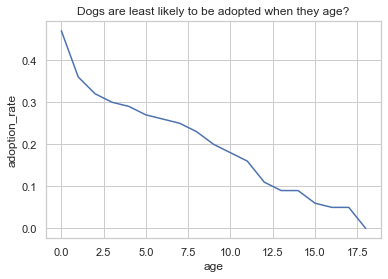

In [121]:
elbow_d = pd.DataFrame({'age': age_at_adoption_d, 'adoption_rate': adoption_rate_d})
sns.lineplot(x="age", y="adoption_rate", data=elbow_d)
plt.title("Dogs are least likely to be adopted when they age?")

Text(0.5, 1.0, 'Age of Cats may be not as big as a factor for adoption rate?')

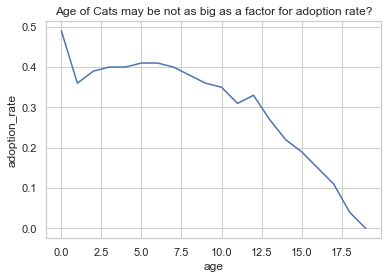

In [118]:
# and the trend of age-based decrease in adoptin rata 
# definitely much more obvious when visualized with lineplot
elbowc = pd.DataFrame({'age': age_at_adoption, 'adoption_rate': adoption_rate})
sns.lineplot(x="age", y="adoption_rate", data=elbowc)
plt.title('Age of Cats may be not as big as a factor for adoption rate?')

In [89]:
# handle names for whole dataframe
df['has_name'] = df[['name']]
df['has_name'] = df.has_name.fillna(value=0)
df['has_name'] = df.has_name.apply(lambda x: 1 if x != 0 else x)
df['has_name'] = df.has_name.astype('int64')

In [94]:
# next need to remove non word or digit in name column
# if there's any nan, need to convert to 0 as well

# has name makes a difference in animal outcome?

Text(0.5, 1, 'Is having a name important for animal adoption?')

<Figure size 1440x360 with 0 Axes>

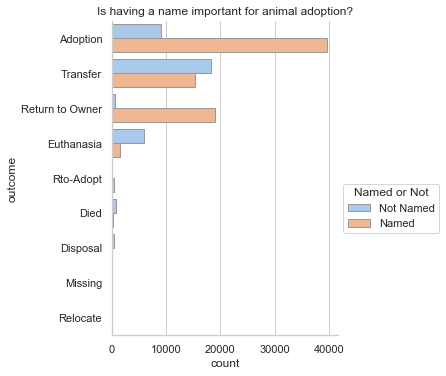

In [125]:
# peek the animal counts in different outcome
plt.figure(figsize=(20,5))
sns.catplot(y="outcome", kind="count", hue = 'has_name',
            palette="pastel", edgecolor=".6",
            data=df, legend=False,
           order = ['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia','Rto-Adopt', 'Died', 'Disposal', 'Missing', 'Relocate'])
plt.legend(title='Named or Not', loc='upper left', labels=['Not Named', 'Named'], bbox_to_anchor=(1, 0.5))
plt.title('Is having a name important for animal adoption?')

In [102]:
# handle names for dog dataframe
dog_df['has_name'] = dog_df[['name']]
dog_df['has_name'] = dog_df.has_name.fillna(value=0)
dog_df['has_name'] = dog_df.has_name.apply(lambda x: 1 if x != 0 else x)
dog_df['has_name'] = dog_df.has_name.astype('int64')

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Text(0.5, 1, 'Is having a name important for dog adoption?')

<Figure size 1440x360 with 0 Axes>

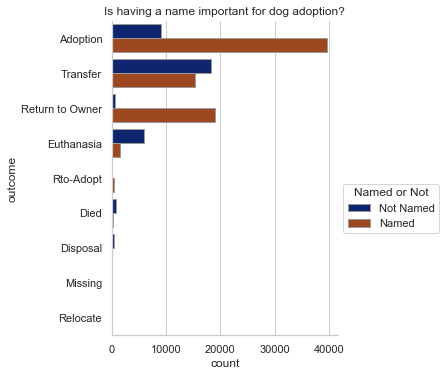

In [126]:
plt.figure(figsize=(20,5))
sns.catplot(y="outcome", kind="count", hue = 'has_name',
            palette="dark", edgecolor=".6",
            data=df, legend=False,
           order = ['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia','Rto-Adopt', 'Died', 'Disposal', 'Missing', 'Relocate'])
plt.legend(title='Named or Not', loc='upper left', labels=['Not Named', 'Named'], bbox_to_anchor=(1, 0.5))
plt.title("Is having a name important for dog adoption?")

In [122]:
# handle names for cat dataframe
cat_df['has_name'] = cat_df[['name']]
cat_df['has_name'] = cat_df.has_name.fillna(value=0)
cat_df['has_name'] = cat_df.has_name.apply(lambda x: 1 if x != 0 else x)
cat_df['has_name'] = cat_df.has_name.astype('int64')

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Text(0.5, 1, 'Is having a name important for cat adoption?')

<Figure size 1440x360 with 0 Axes>

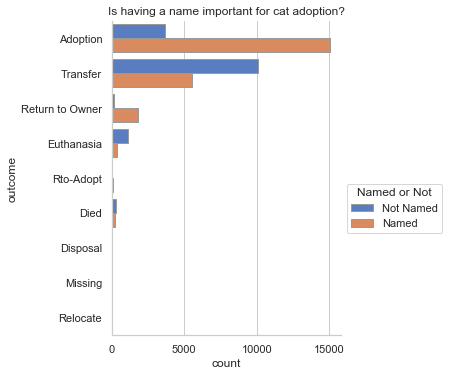

In [127]:
plt.figure(figsize=(20,5))
sns.catplot(y="outcome", kind="count", hue = 'has_name',
            palette="muted", edgecolor=".6",
            data=cat_df, legend=False,
           order = ['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia','Rto-Adopt', 'Died', 'Disposal', 'Missing', 'Relocate'])
plt.legend(title='Named or Not', loc='upper left', labels=['Not Named', 'Named'], bbox_to_anchor=(1, 0.5))
plt.title("Is having a name important for cat adoption?")

## Initial peek at breed & color

In [133]:
# handle color and breed
print(f"""
peek unique breed: 
{df.breed.nunique()}
-
peek unique colors:
{df.color.nunique()}
""")


peek unique breed: 
2504
-
peek unique colors:
580



## Prepare breed

In [134]:
import re

In [217]:
# 78% contain the word mix
# True == 1
print(" Percentage of mutt containing the word 'Mix': {:.2f}%".format(df.breed.str.contains('Mix').mean()))

 Percentage of mutt containing the word 'Mix': 0.78%


In [218]:
# 9% contain the word "/" which also means they're not pure breedprint(" Percentage of mutt containing the word 'Mix': {:.2f}%".format(
print(" Percentage of mutt containing forward slash(es): {:.2f}%".format(df.breed.str.contains('/').mean()))

 Percentage of mutt containing the forward slash: 0.09%


In [212]:
df["breed_type"] = np.where((df.breed.str.contains("/")|df.breed.str.contains("Mix")), "mix", "pure")

In [213]:
df.breed_type.value_counts()

mix     97834
pure    13878
Name: breed_type, dtype: int64

In [377]:
# handling dog color 
dog_df_breed_counts = dog_df.breed.value_counts()
dog_df_breed_others = list(dog_df_breed_counts[dog_df_breed_counts < 300].index)
dog_df['top_breed'] = dog_df.breed.replace(dog_df_breed_others, 'Others')
print(dog_df['top_breed'].nunique())

36


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [378]:
dog_df["breed_type"] = np.where((dog_df.top_breed.str.contains("/")|dog_df.breed.str.contains("Mix")), "mix", "pure")

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [382]:
dog_df.breed.value_counts()

Pit Bull Mix                          8084
Labrador Retriever Mix                6334
Chihuahua Shorthair Mix               6025
German Shepherd Mix                   2780
Australian Cattle Dog Mix             1403
                                      ... 
Plott Hound/Whippet                      1
Cairn Terrier/Cardigan Welsh Corgi       1
Lowchen/Miniature Poodle                 1
French Bulldog/Dachshund                 1
Labrador Retriever/Finnish Spitz         1
Name: breed, Length: 2214, dtype: int64

## Explore breed

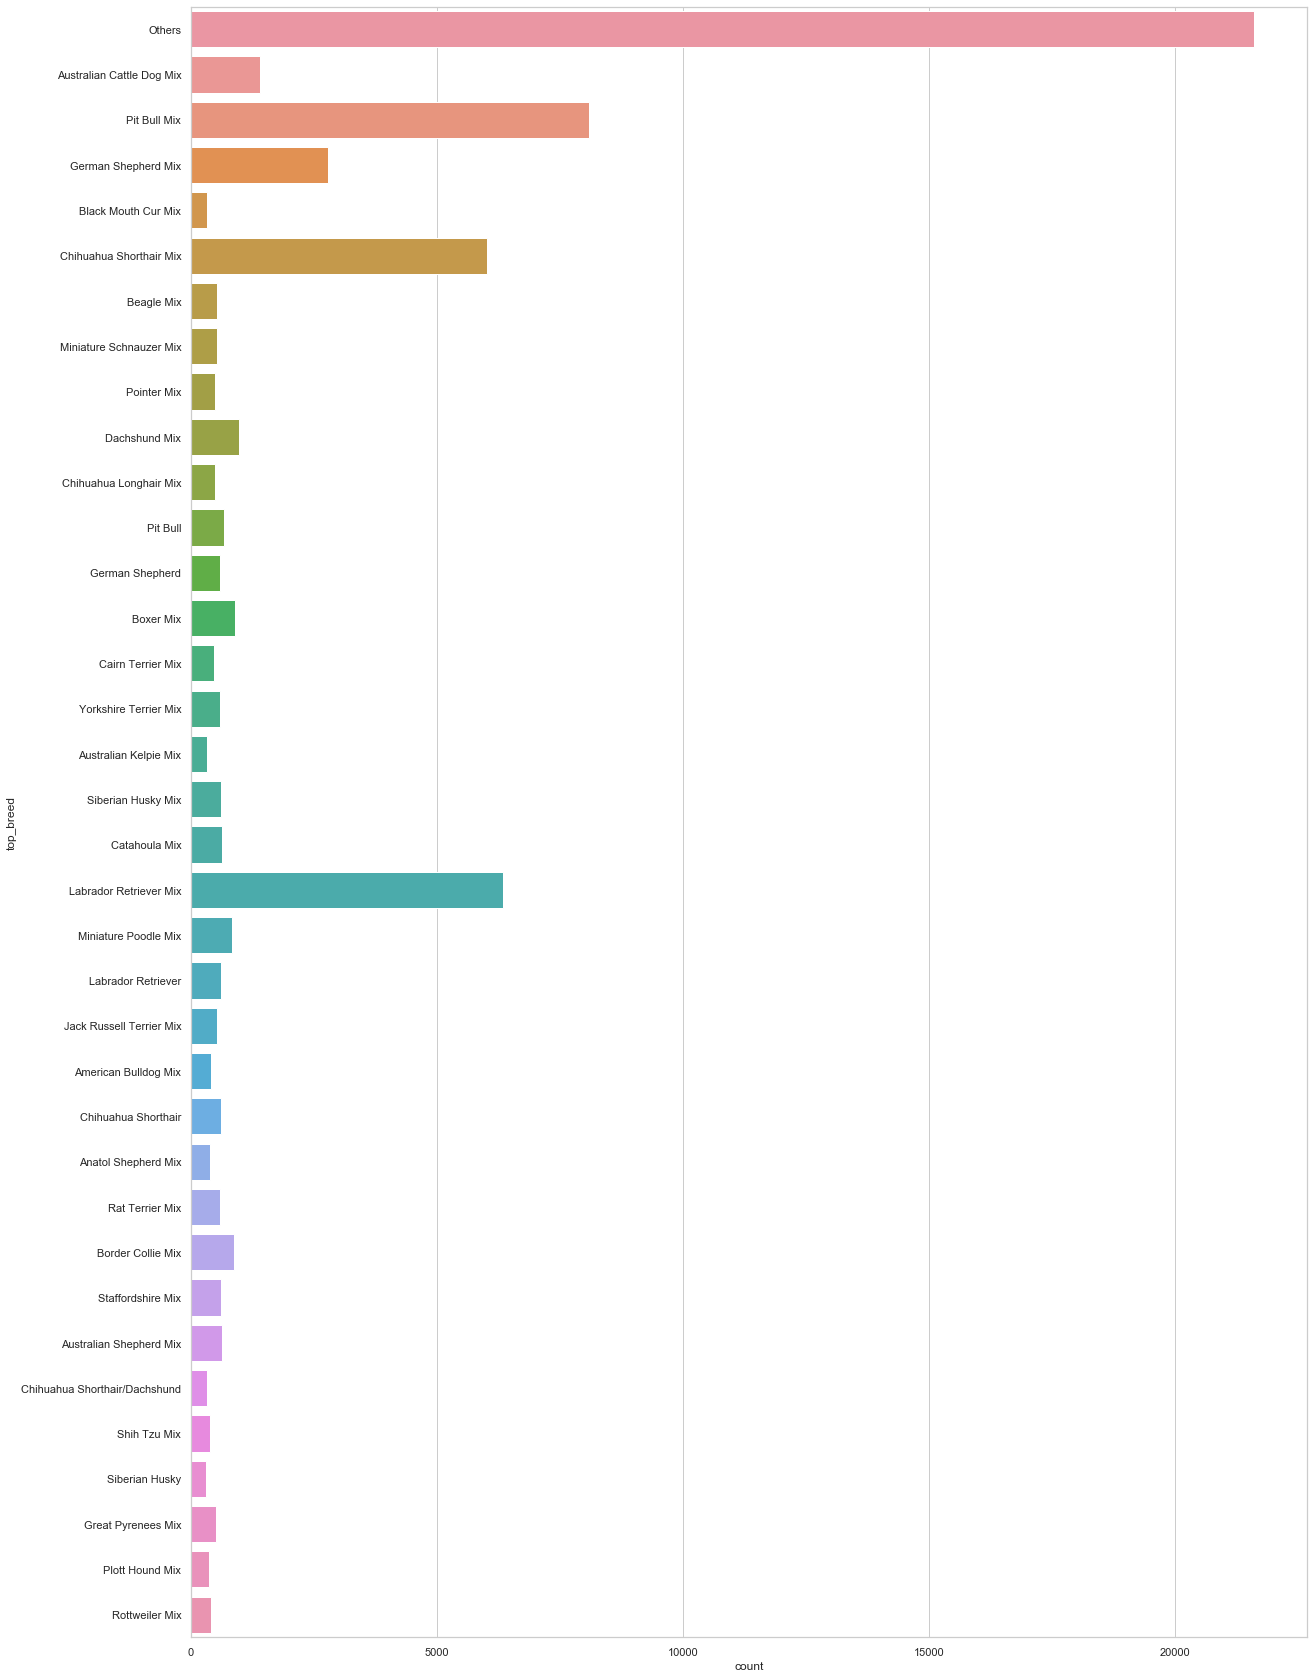

In [386]:
plt.figure(figsize=(20,30))
sns.countplot(y='top_breed', data=dog_df)


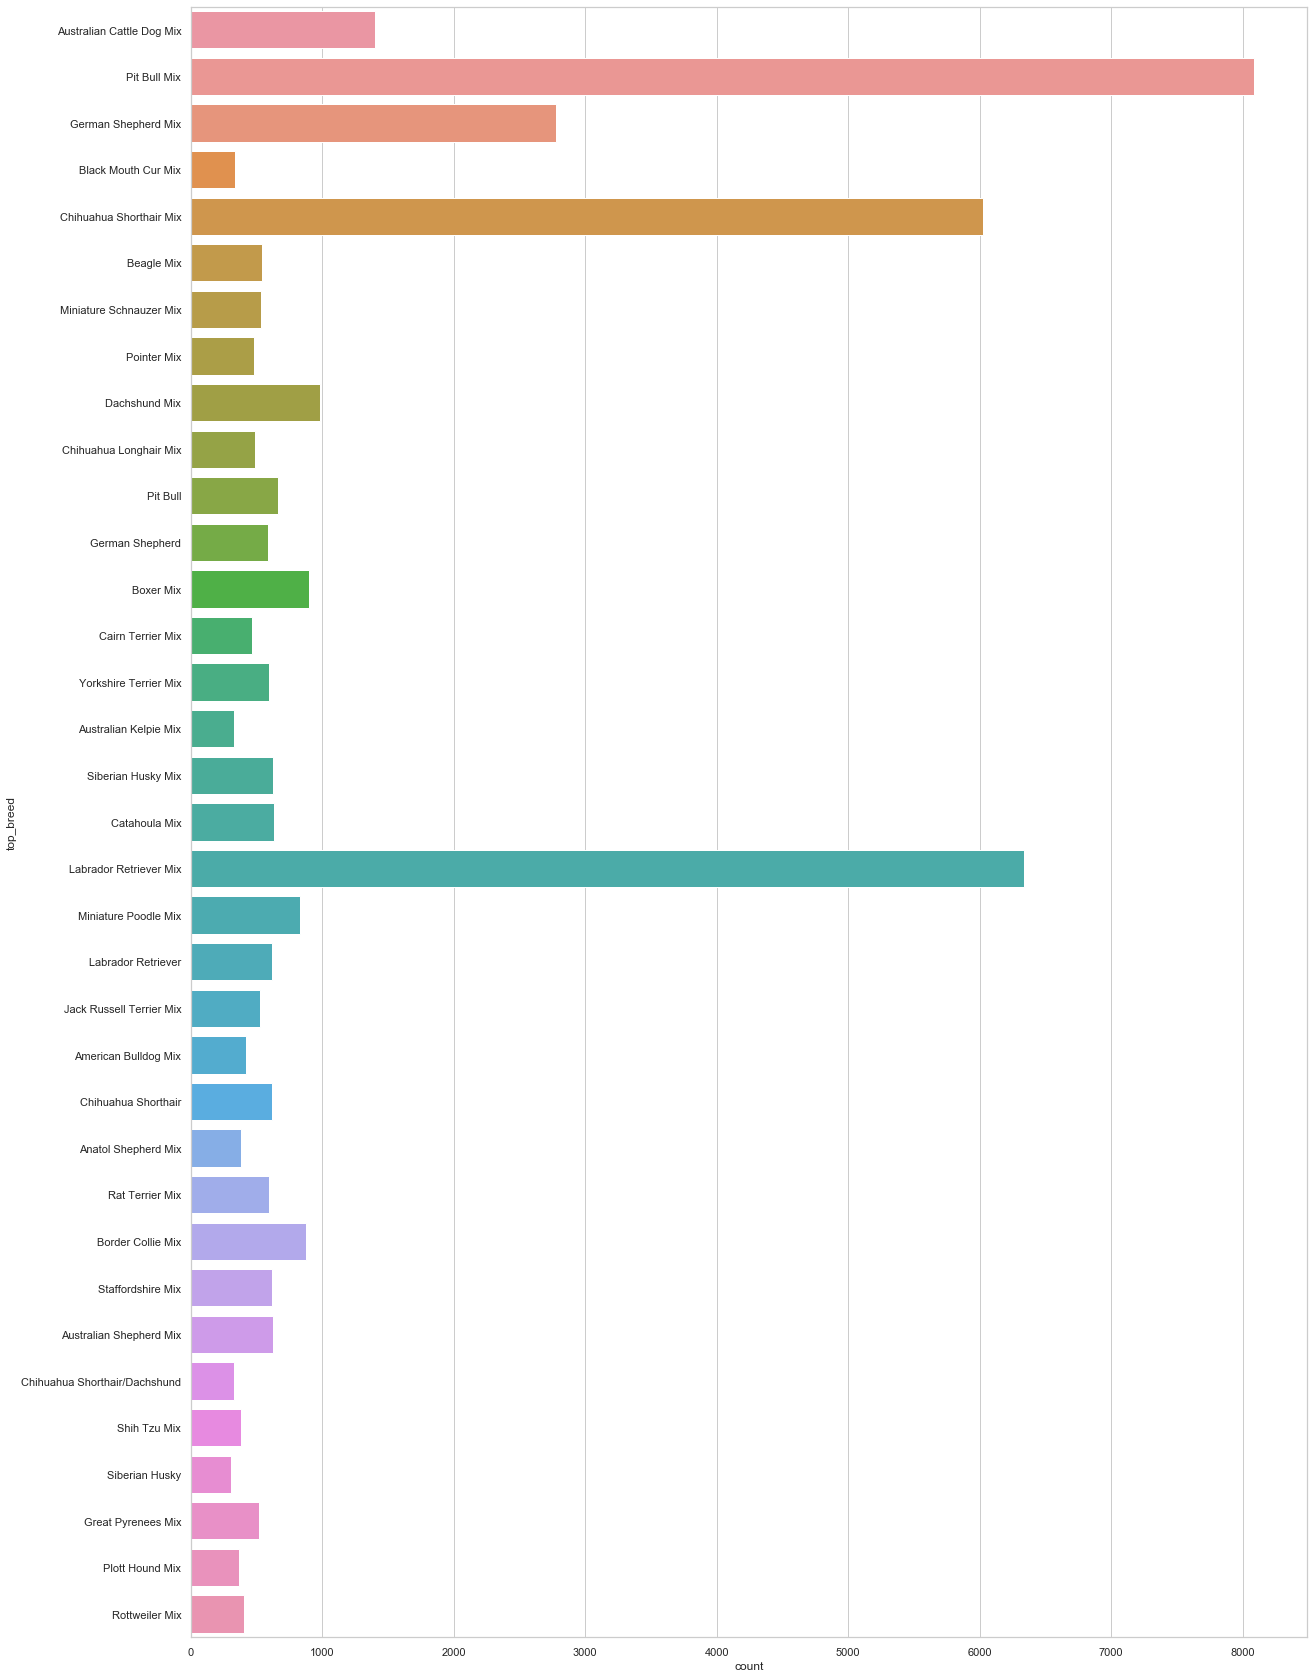

In [395]:
tmp = dog_df.copy()
tmp = tmp[tmp.top_breed != 'Others']

plt.figure(figsize=(20,30))
sns.countplot(y = 'top_breed', data = tmp)


Text(0.5, 1.0, 'What dog breeds are the most adopted?')

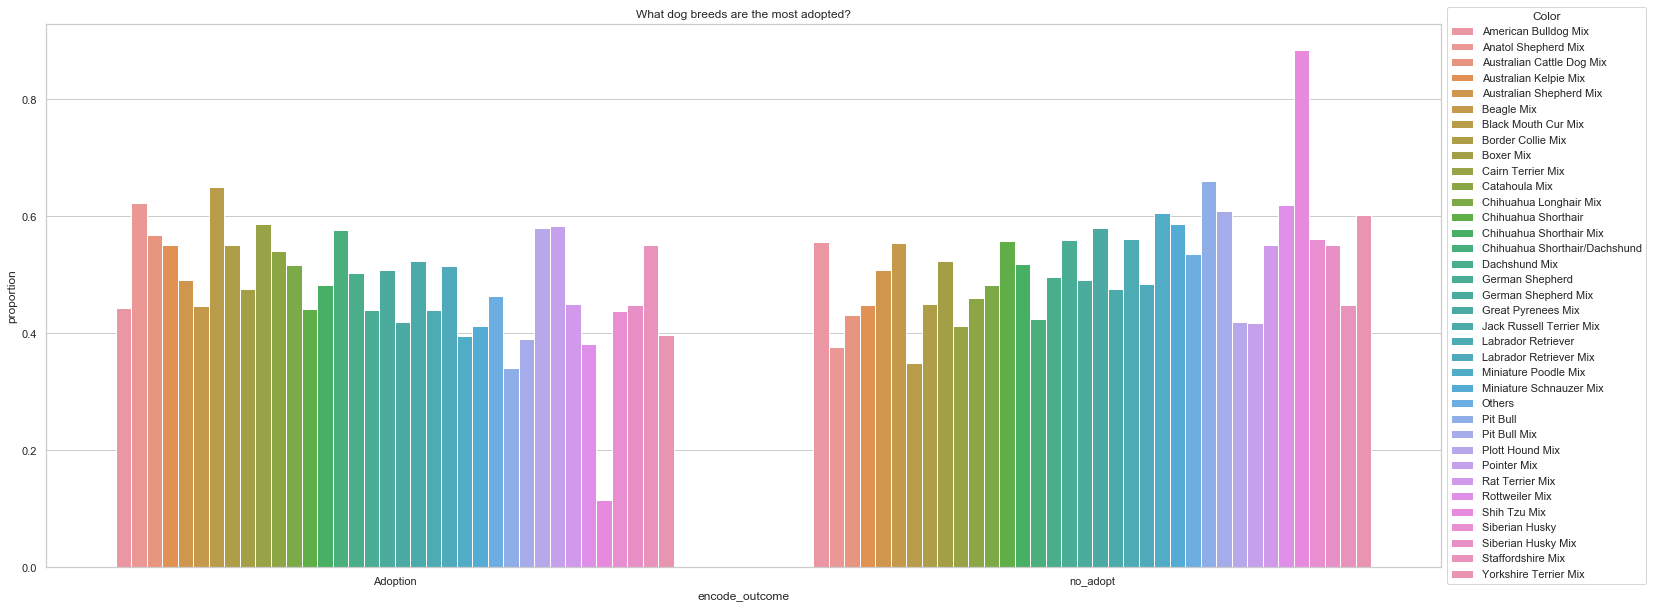

In [412]:
# each color, adopted% vs non-adopted%
plt.figure(figsize=(25,10))
x, y, hue = "encode_outcome", "proportion", "top_breed"
order = ['Adoption', 'no_adopt']

prop_df = (dog_df[x]
           .groupby(dog_df[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

(sns.barplot(x=x, y=y, hue=hue, data=prop_df, 
             order = ['Adoption', 'no_adopt']))
plt.legend(title='Color', loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('What dog breeds are the most adopted?')

# (df[x]
#  .groupby(df[hue])
#  .value_counts(normalize=True)
#  .rename(y)
#  .reset_index()
#  .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

In [399]:
vc = tmp.top_breed.value_counts()
vc = vc[vc>1000].index.tolist()
print("The list of most commonly seen shelter dog breeds is: ")
print(vc)


The list of most commonly seen shelter dog breeds is: 
['Pit Bull Mix', 'Labrador Retriever Mix', 'Chihuahua Shorthair Mix', 'German Shepherd Mix', 'Australian Cattle Dog Mix']


In [405]:
tmp = tmp[tmp.top_breed.isin(vc)]
tmp.top_breed.value_counts()


Pit Bull Mix                 8084
Labrador Retriever Mix       6334
Chihuahua Shorthair Mix      6025
German Shepherd Mix          2780
Australian Cattle Dog Mix    1403
Name: top_breed, dtype: int64

In [411]:
print("""The overall adoption rate of all dogs regardless of breed is: {:.2f}"""
.format(len(dog_df[dog_df.encode_outcome == 'Adoption'])/len(dog_df)))

print("""The most common breed adoption rate is: {:.2f}"""
.format(len(tmp[tmp.encode_outcome == 'Adoption'])/len(tmp)))



The overall adoption rate of all dogs regardless of breed is: 0.47
The most common breed adoption rate is: 0.47


## Explore color & prepare color

In [221]:
# wooo, so many different color combinations!
df.color.nunique()

580

In [219]:
# handling color 
df_color_counts = df.color.value_counts()
df_color_others = list(df_color_counts[df_color_counts < 300].index)
df['top_colors'] = df.color.replace(df_color_others, 'Others')
print(df['top_colors'].nunique())

52


In [222]:
# handling dog color 
dog_df_color_counts = dog_df.color.value_counts()
dog_df_color_others = list(dog_df_color_counts[dog_df_color_counts < 300].index)
dog_df['top_colors'] = dog_df.color.replace(dog_df_color_others, 'Others')
print(dog_df['top_colors'].nunique())

33


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


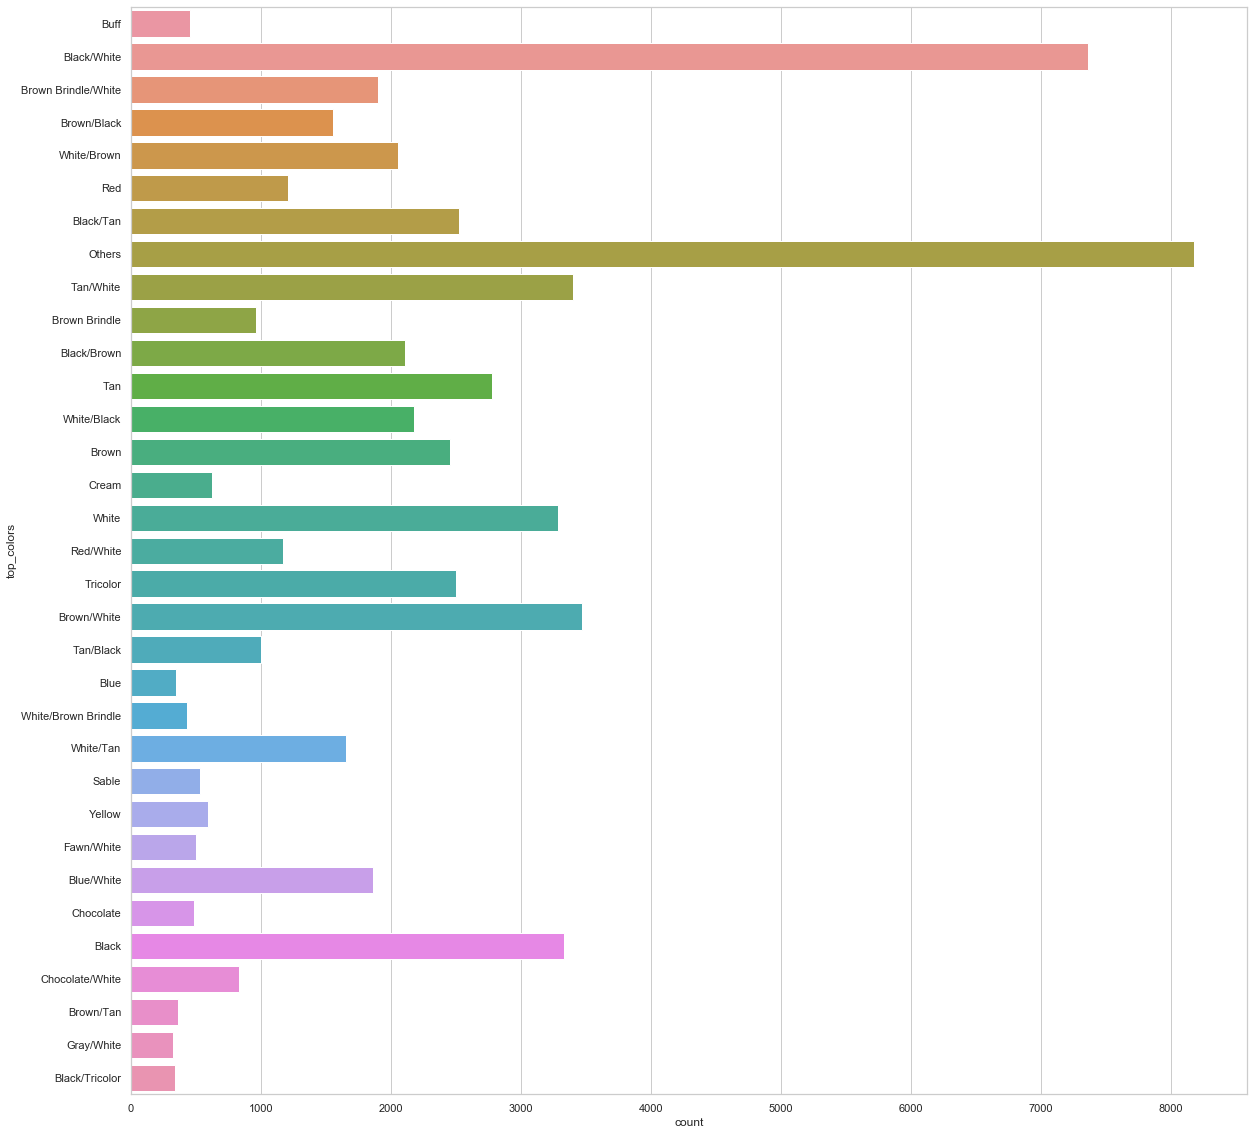

In [316]:
plt.figure(figsize=(20,20))

sns.countplot(y='top_colors', data=dog_df)

Text(0.5, 1, 'What colors of dogs are the most adopted?')

<Figure size 1440x360 with 0 Axes>

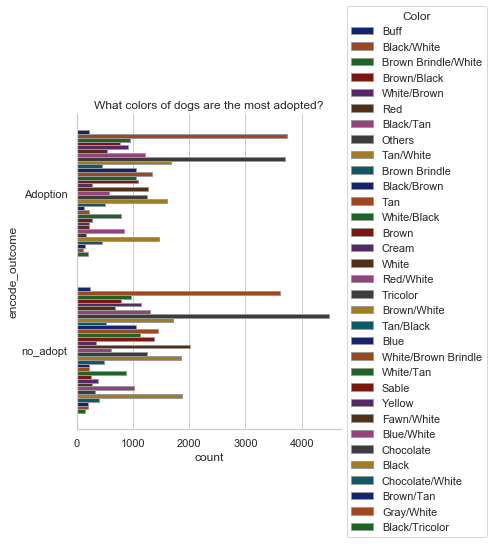

In [234]:
# plot different color vs adopt/no-adopt
plt.figure(figsize=(20,5))
sns.catplot(y="encode_outcome", kind="count", hue = 'top_colors',
            palette="dark", edgecolor=".6",
            data=dog_df, legend=False,
           order = ['Adoption', 'no_adopt'])
plt.legend(title='Color', loc='center left', labels=list(dog_df['top_colors'].unique()), bbox_to_anchor=(1, 0.5))
plt.title('What colors of dogs are the most adopted?')


Text(0.5, 1.0, 'What colors of dogs are the most adopted?')

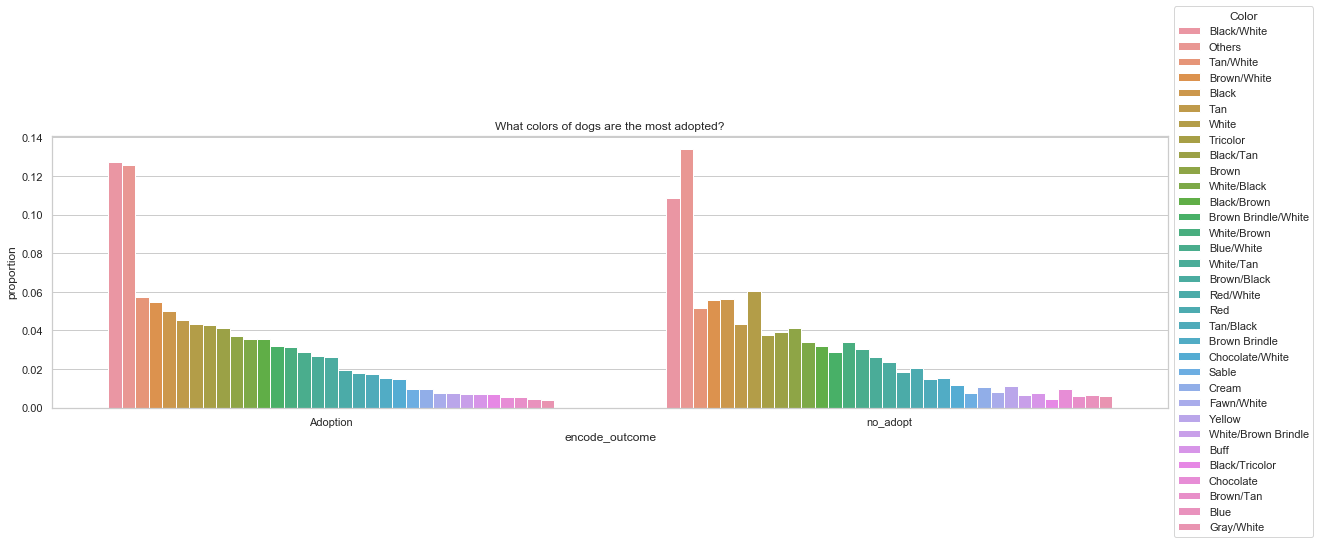

In [312]:
# proportion of colors
# black/white dogs and other colors are predominant colors
# making 24% in both adopted and non-adopted population
# which is the double amount of dogs compared with the third highest number (color group)
plt.figure(figsize=(20,5))
x, y, hue = "encode_outcome", "proportion", "top_colors"
order = ['Adoption', 'no_adopt']

prop_df = (dog_df.groupby(x)[hue]
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

(sns.barplot(x=x, y=y, hue=hue, data=prop_df, 
             order = ['Adoption', 'no_adopt']))
plt.legend(title='Color', loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('What colors of dogs are the most adopted?')

In [311]:
(dog_df.
 groupby("encode_outcome")["top_colors"]
 .value_counts(normalize = True)
 .sort_values(ascending = False)
 .unstack()).T

encode_outcome,Adoption,no_adopt
top_colors,,
Black,0.049784,0.056045
Black/Brown,0.035638,0.031722
Black/Tan,0.041249,0.039270
Black/Tricolor,0.006869,0.004164
Black/White,0.127249,0.108495
Blue,0.004625,0.006440
Blue/White,0.028803,0.030434
Brown,0.036828,0.041217
Brown Brindle,0.015302,0.015457


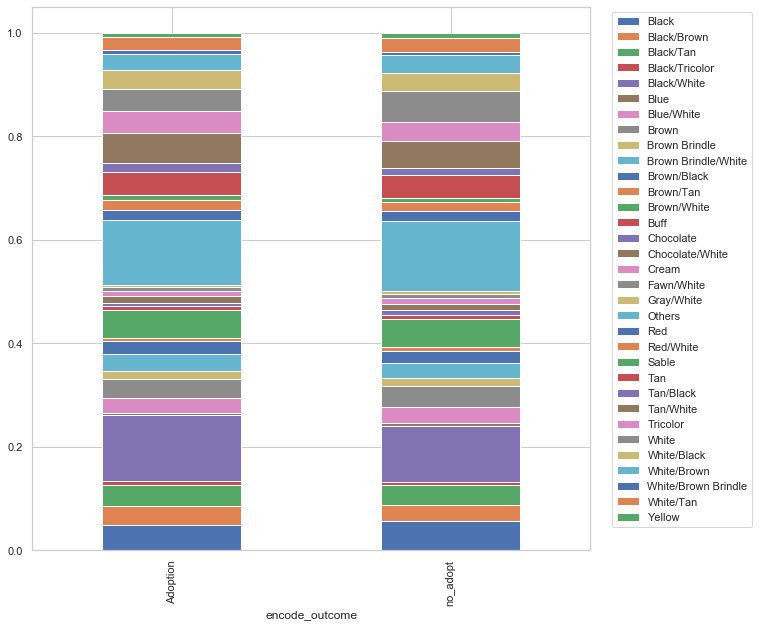

In [292]:
(dog_df.
 groupby("encode_outcome")
 ["top_colors"]
 .value_counts(normalize = True)
 .unstack()
 .plot(kind = "bar", stacked = "True", figsize=(10,10))
 .legend(bbox_to_anchor=(1.3, 1)))

In [306]:
(dog_df[x]
           .groupby(dog_df[hue])
           .value_counts(normalize=True)
            .sort_values(ascending = False)).unstack()

encode_outcome,Adoption,no_adopt
top_colors,,
Black,0.438981,0.561019
Black/Brown,0.497390,0.502610
Black/Tan,0.480586,0.519414
Black/Tricolor,0.592375,0.407625
Black/White,0.508148,0.491852
Blue,0.387464,0.612536
Blue/White,0.454643,0.545357
Brown,0.440423,0.559577
Brown Brindle,0.465839,0.534161


Text(0.5, 1.0, 'What colors of dogs are the most adopted?')

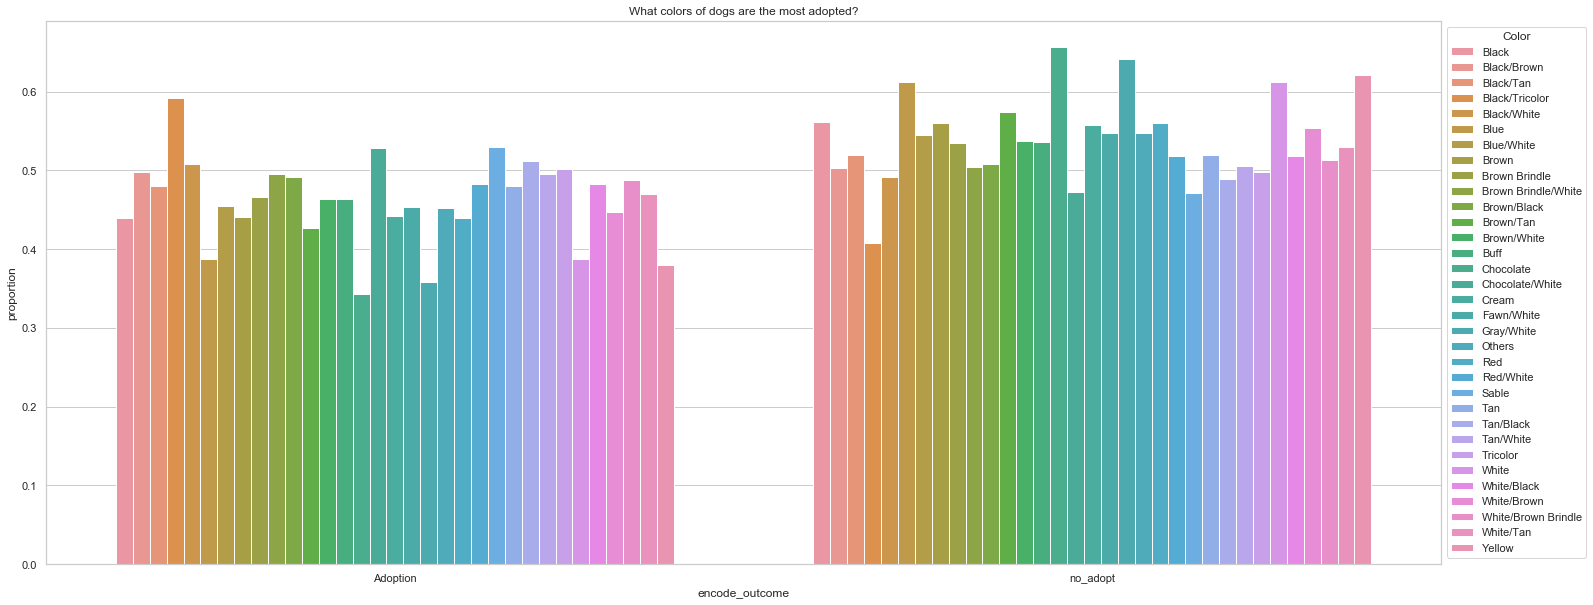

In [322]:
# each color, adopted% vs non-adopted%
plt.figure(figsize=(25,10))
x, y, hue = "encode_outcome", "proportion", "top_colors"
order = ['Adoption', 'no_adopt']

prop_df = (dog_df[x]
           .groupby(dog_df[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

(sns.barplot(x=x, y=y, hue=hue, data=prop_df, 
             order = ['Adoption', 'no_adopt']))
plt.legend(title='Color', loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('What colors of dogs are the most adopted?')

# (df[x]
#  .groupby(df[hue])
#  .value_counts(normalize=True)
#  .rename(y)
#  .reset_index()
#  .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

In [321]:
# extract the colors where proportion adopt > no-adopt
prop_df

,top_colors,encode_outcome,proportion
0,Black,no_adopt,0.561019
1,Black,Adoption,0.438981
2,Black/Brown,no_adopt,0.502610
3,Black/Brown,Adoption,0.497390
4,Black/Tan,no_adopt,0.519414
...,...,...,...
61,White/Brown Brindle,Adoption,0.487298
62,White/Tan,no_adopt,0.530157
63,White/Tan,Adoption,0.469843
64,Yellow,no_adopt,0.620805


In [325]:
# black/ tricolor is the only color having much higher adoption rate (vs all other fate)
# explore other features within this group of dogs

# M:F relatively close
dog_df[dog_df.top_colors == "Black/Tricolor"].sex_transformed.value_counts()

Male      179
Female    162
Name: sex_transformed, dtype: int64

In [338]:
dog_gen = dog_df[dog_df.encode_outcome == "Adoption"].age_transformed
dog_tri = dog_df[(dog_df.top_colors == "Black/Tricolor")&(dog_df.encode_outcome == "Adoption")].age_transformed

In [345]:
print(f"""
Median age of adopted dogs (overall population): {dog_gen.mode()}
Median age of adopted dogs (black/tri-color dogs only): {dog_tri.mode()}""")


Median age of adopted dogs (overall population): 0    365.0
dtype: float64
Median age of adopted dogs (black/tri-color dogs only): 0    365.0
dtype: float64


In [346]:
print(f"""
Average age of adopted dogs (overall population): {dog_gen.mean()}
Average age of adopted dogs (black/tri-color dogs only): {dog_tri.mean()}""")


Average age of adopted dogs (overall population): 711.0877852212059
Average age of adopted dogs (black/tri-color dogs only): 525.0990099009902


In [350]:
tstat, p = stats.ttest_ind(dog_gen, dog_tri)
print("""Statistical test for all adopted dogs versus black/tricolor dogs: 
T-test {:.2f}, p-value{:.2f}""".format(tstat,p))

Statistical test for all adopted dogs versus black/tricolor dogs: 
T-test 3.06, p-value0.00


Text(0.5, 1.0, "What's the age distribution for all adopted dogs?")

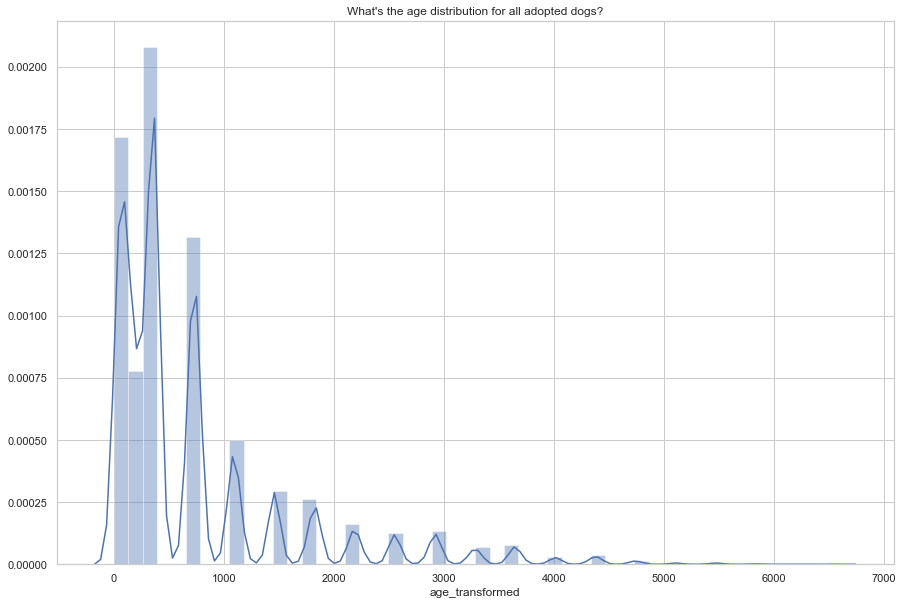

In [363]:
plt.figure(figsize=(15,10))

(dog_df[dog_df.encode_outcome == "Adoption"]
 .age_transformed
.pipe(sns.distplot))

plt.title("What's the age distribution for all adopted dogs?")

Text(0.5, 1.0, "What's the age distribution for all adopted Black/Tricolor dogs?")

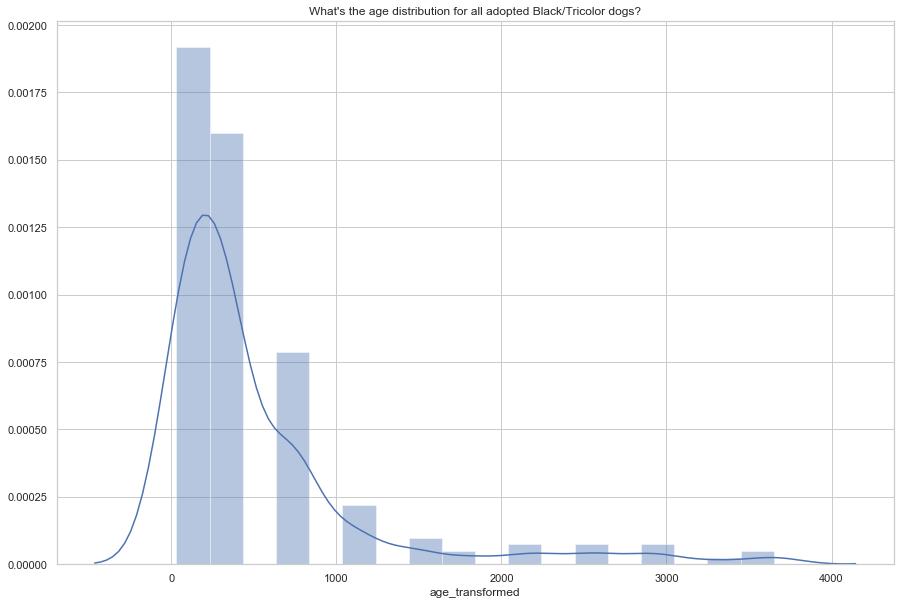

In [362]:
plt.figure(figsize=(15,10))

(dog_df[(dog_df.encode_outcome == "Adoption")&(dog_df.top_colors == "Black/Tricolor")]
 .age_transformed
.pipe(sns.distplot))

plt.title("What's the age distribution for all adopted Black/Tricolor dogs?")

In [376]:
print(f"Look at the age by numbers: Overall population/ all colors - adopted: {dog_df[(dog_df.encode_outcome == 'Adoption')].age_transformed.value_counts()}")

print(f"Black/Tricolor population/ adopted: {dog_df[(dog_df.encode_outcome == 'Adoption')&(dog_df.top_colors == 'Black/Tricolor')].age_transformed.value_counts()}")


Look at the age by numbers: Overall population/ all colors - adopted: 365.0     6552
730.0     5083
61.0      3750
1095.0    1931
1460.0    1134
1825.0    1018
30.5      1014
122.0      938
91.5       933
152.5      895
183.0      809
244.0      770
305.0      758
2190.0     621
213.5      533
2920.0     514
2555.0     486
274.5      424
335.5      310
3650.0     298
3285.0     275
4380.0     137
4015.0     110
4745.0      57
5475.0      21
5110.0      20
5840.0       6
0.0          4
6205.0       2
6570.0       2
28.0         1
35.0         1
Name: age_transformed, dtype: int64
Black/Tricolor population/ adopted: 365.0     44
730.0     32
61.0      28
152.5     12
91.5      11
122.0     10
244.0     10
1095.0     9
305.0      8
213.5      7
30.5       7
1460.0     4
2920.0     3
2190.0     3
183.0      3
2555.0     3
274.5      3
1825.0     2
3650.0     2
3285.0     1
Name: age_transformed, dtype: int64


In [364]:
dog_df[dog_df.top_colors == "Black/Tricolor"].has_name.value_counts()

1    266
0     75
Name: has_name, dtype: int64

In [225]:
# handling cat color 
cat_df_color_counts = cat_df.color.value_counts()
cat_df_color_others = list(cat_df_color_counts[cat_df_color_counts < 300].index)
cat_df['top_colors'] = cat_df.color.replace(cat_df_color_others, 'Others')
print(cat_df['top_colors'].nunique())

21


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [226]:
cat_df.top_colors.value_counts()

Brown Tabby           5715
Black                 4905
Others                4050
Black/White           3561
Brown Tabby/White     3067
Orange Tabby          2806
Tortie                1866
Calico                1828
Blue Tabby            1476
Blue                  1454
Orange Tabby/White    1438
Torbie                1190
Blue/White            1044
Blue Tabby/White       727
Cream Tabby            680
White/Black            656
Lynx Point             534
Seal Point             408
White/Brown Tabby      402
White                  375
Cream Tabby/White      339
Name: top_colors, dtype: int64

In [ ]:
# take care of months
df.age_destiny = df.age_destiny.apply(lambda x: re.sub(r'([^\d+])', '',x) if 'months' in x else x)
df.age_destiny = df.age_destiny.apply(lambda x: re.sub(r'([^\d+])', '',x) if 'month' in x else x)

In [128]:
def name_adopt_relationship(data):
    # get unique names
    name_list = data.Name.dropna().unique()
    # convert ndarray to list for iteration
    name_list = list(name_list)
    # create empty lists to hold calculated data
    name = []
    adopt_rate = []
    count = []
    dict = {}
    for n in name_list:
        # store name into list
        name.append(n)
        # calculate adoption rate for each name 
        # divide by all outcomes attached with that particular name
        rate = len(data[(data.Name == n) & (data["Outcome Type"] == "Adoption")]) / len(data[data.Name == n])
        # store name into rate
        adopt_rate.append(rate)
        count.append(len(data[data.Name == n]))
    dict = {'pet_name': name, 'name_count': count, 'adopt_rate': adopt_rate}
    return pd.DataFrame(dict)

In [ ]:
cat = name_adopt_relationship(cat)
cat

In [ ]:
cat[cat.name_count >= 50].sort_values(by = 'adopt_rate', ascending = False)

In [129]:
dog_result = name_adopt_relationship(dog)
dog_result

KeyboardInterrupt: 

In [ ]:
dog_result[dog_result.name_count >= 30].sort_values(by = 'adopt_rate', ascending = False)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset
crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="total", y="abbrev", data=crashes,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="alcohol", y="abbrev", data=crashes,
            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)

In [ ]:
df[df.Name == 'Sasha']["Outcome Type"].value_counts()

In [ ]:
df[df.Name == 'Rocky']["Outcome Type"].value_counts()

In [ ]:
len(df[(df.Name == 'Rocky') & (df["Outcome Type"] == "Adoption")]) / len(df[df.Name == 'Rocky'])

In [ ]:
df.groupby('Name')['Outcome Type'].nunique().sort_values(ascending=False)

In [ ]:
df_19[df_19.DateTime == df_19.MonthYear].info()

In [ ]:
df_19['Animal Type'].value_counts()

In [ ]:
df_19.info()

In [ ]:
prepare.report_col_with_null(df_19)

Using real data from Animal Care Services and a Decision Tree Classifier, I was able to predict if an animal would be euthanized or adopted with an accuracy of over 90%. To achieve this result I engineered new features by thinking about what factors contribute to an animal being adopted and also used undersampling to balance the classes. I then used cross-validation and tried several classification models to determine which performed the best.

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
df.info()

In [ ]:
df.AnimalType.unique()

In [ ]:
# ID seems unique
df.AnimalID.nunique()

In [ ]:
df.head()

In [ ]:
df.OutcomeType.value_counts().plot(kind='bar')

**Initial thought after peek at data**
1. sep animal type
2. animals w/o names might have worse outcome
3. more adoption: neutered/ spayed ones, young, specific breed/ color

A lot of encoding?

In [ ]:
# missing a lot of names
# animals without names > worse outcome?
df.Name.isnull().sum()

In [ ]:
# this works too lol
check = df.columns[df.isnull().any()]
check

In [ ]:
null_pd = prepare.report_col_with_null(df)

In [ ]:
null_pd

In [ ]:
pd.crosstab(df.AnimalType, df.OutcomeType).apply(lambda r: r/r.sum(), axis=1)

In [ ]:
pd.crosstab(df.OutcomeType, df.AnimalType).apply(lambda r: r/r.sum(), axis=1)

In [ ]:
df.replace(r'^\s*$', np.nan, regex = True, inplace = True) 

In [ ]:
(df.DateTime.value_counts(sort = False)).plot()